#ForeverAlone - predicting depression severity in individuals

This notebook is authored by Lynnette Tee.
##Introduction
In this project, I used a dataset derived from a depression survey to predict depression severity levels in individuals using three distinct models.

###Dataset
The [dataset](https://www.kaggle.com/antonaks/suicide-attempt-prediction-foreveralone-dataset) is obtained from Kaggle by the user, LiamLarsen. The row represents answers from respondents while the columns are survey questions. 

The dataset contains two variables, `Depressed` and `AttemptedSuicide`, that will define labels for my target, `DepressionSeverity`. 

Here is a rough outline of the process:
0. Import dataset
1. EDA and Preprocessing Data
3. Train and Validate Models
4. Test Models
5. Analyze and Discuss Results

## Import dataset

To begin, import the relevant libraries:

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

Load `'foreverAlone.csv'` onto the notebook:

In [0]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/predict-depression'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Store dataset as a Pandas dataframe object in `df`:

In [0]:
df = pd.read_csv("{}/ForeverAlone.csv".format(data_dir))

Rename columns:

In [0]:
df.columns = ['Timestamp', 'Gender', 'SexualOrientation', 'Age','IncomeLevel','Race','Body','NotHadSex','ProstitutionLegalAtPlace','WouldPayForSex','NumFriends','HasSocialAnxiety','Depressed','TypeOfHelp','AttemptedSuicide','CurrentlyEmployed','JobTitle','Education','SelfHelp']

#verify change
df.head()

,Timestamp,Gender,SexualOrientation,Age,IncomeLevel,Race,Body,NotHadSex,ProstitutionLegalAtPlace,WouldPayForSex,NumFriends,HasSocialAnxiety,Depressed,TypeOfHelp,AttemptedSuicide,CurrentlyEmployed,JobTitle,Education,SelfHelp
0,5/17/2016 20:04:18,Male,Straight,35,"$30,000 to $39,999",White non-Hispanic,Normal weight,Yes,No,No,0.0,Yes,Yes,"wingman/wingwoman, Set me up with a date",Yes,Employed for wages,mechanical drafter,Associate degree,None
1,5/17/2016 20:04:30,Male,Bisexual,21,"$1 to $10,000",White non-Hispanic,Underweight,Yes,No,No,0.0,Yes,Yes,"wingman/wingwoman, Set me up with a date, date...",No,Out of work and looking for work,-,"Some college, no degree",join clubs/socual clubs/meet ups
2,5/17/2016 20:04:58,Male,Straight,22,$0,White non-Hispanic,Overweight,Yes,No,No,10.0,Yes,Yes,I don't want help,No,Out of work but not currently looking for work,unemployed,"Some college, no degree",Other exercise
3,5/17/2016 20:08:01,Male,Straight,19,"$1 to $10,000",White non-Hispanic,Overweight,Yes,Yes,No,8.0,Yes,Yes,date coaching,No,A student,student,"Some college, no degree",Joined a gym/go to the gym
4,5/17/2016 20:08:04,Male,Straight,23,"$30,000 to $39,999",White non-Hispanic,Overweight,No,No,Yes and I have,10.0,No,Yes,I don't want help,No,Employed for wages,Factory worker,"High school graduate, diploma or the equivalen...",None


#EDA and Preprocessing

In this section, explore the dataset to have a rough idea of its contents, as well as clean the dataset so that it is ready to be fed into the models.

How big is the dataset?

In [0]:
df.shape

(469, 19)

There are 469 rows (corresponding to respondents' answers) and 19 columns (corresponding to survey questions).

What are the datatypes of each column?

In [0]:
df.dtypes

Timestamp                    object
Gender                       object
SexualOrientation            object
Age                           int64
IncomeLevel                  object
Race                         object
Body                         object
NotHadSex                    object
ProstitutionLegalAtPlace     object
WouldPayForSex               object
NumFriends                  float64
HasSocialAnxiety             object
Depressed                    object
TypeOfHelp                   object
AttemptedSuicide             object
CurrentlyEmployed            object
JobTitle                     object
Education                    object
SelfHelp                     object
dtype: object

Excluding `Timestamp`, there are 2 numerical variables and 16 categorical variables.

## Feature selection

Which of the columns are good feature candidates?

Decide by asking:
1. Could the variable (column) be a possible contributing factor to depression?
2. Could its inputs be grouped into independent categories?

Keep in mind that number of features will determine model performance. If the number of features is very large relative to the dataset size, there is a risk of overfitting the models. On the contrary, if there are not enough features, the models may lose their predictive power. 

Given that this dataset has 469 samples, I adjusted the tightness of my selection to arrive at 13 features. 

For each column, observe its inputs to determine if it is a suitable feature to include:

In [0]:
#begin after `Timestamp` (will be discarded soon)
for column in df.columns[1:]: 
    print(f'columns: {column}\nInput set:{df[column].unique()}\n')

columns: Gender
Input set:['Male' 'Female' 'Transgender male' 'Transgender female']

columns: SexualOrientation
Input set:['Straight' 'Bisexual' 'Gay/Lesbian']

columns: Age
Input set:[35 21 22 19 23 24 20 33 32 25 29 17 28 26 18 55 16 38 45 30 15 34 70 12
 36 31 27 57 44 41 37 39 14 48 42]

columns: IncomeLevel
Input set:['$30,000 to $39,999' '$1 to $10,000' '$0' '$50,000 to $74,999'
 '$20,000 to $29,999' '$10,000 to $19,999' '$75,000 to $99,999'
 '$174,999 to $199,999' '$100,000 to $124,999' '$40,000 to $49,999'
 '$200,000 or more']

columns: Race
Input set:['White non-Hispanic' 'Hispanic (of any race)' 'Asian' 'white and asian'
 'caucasian' 'Black' 'Middle Eastern' 'half Arab' 'Mixed race' 'Pakistani'
 'helicopterkin' 'Turkish' 'Indian' 'Native american' 'Mixed' 'mixed'
 'Mixed white/asian' 'indian' 'Multi' 'Native American mix'
 'North African' 'Half Asian half white' 'White and Native American'
 'First two answers. Gender is androgyne, not male; sexuality is asexual, not bi.'
 'Eu

Dropping disqualified columns,

In [0]:
df = df.drop(['Timestamp','SelfHelp', 'JobTitle', 'TypeOfHelp', 'CurrentlyEmployed', 'NotHadSex'], axis = 1)
df.head()

,Gender,SexualOrientation,Age,IncomeLevel,Race,Body,ProstitutionLegalAtPlace,WouldPayForSex,NumFriends,HasSocialAnxiety,Depressed,AttemptedSuicide,Education
0,Male,Straight,35,"$30,000 to $39,999",White non-Hispanic,Normal weight,No,No,0.0,Yes,Yes,Yes,Associate degree
1,Male,Bisexual,21,"$1 to $10,000",White non-Hispanic,Underweight,No,No,0.0,Yes,Yes,No,"Some college, no degree"
2,Male,Straight,22,$0,White non-Hispanic,Overweight,No,No,10.0,Yes,Yes,No,"Some college, no degree"
3,Male,Straight,19,"$1 to $10,000",White non-Hispanic,Overweight,Yes,No,8.0,Yes,Yes,No,"Some college, no degree"
4,Male,Straight,23,"$30,000 to $39,999",White non-Hispanic,Overweight,No,Yes and I have,10.0,No,Yes,No,"High school graduate, diploma or the equivalen..."


The 13 kept features are `Gender`, `SexualOrientation`, `Age`, `IncomeLevel`, `Race`, `Body`, `ProstitutionLegalAtPlace`, `WouldPayForSex`, `NumFriends`, `HasSocialAnxiety`,  and `Education`.

## Creating target column - DepressionSeverity

As my goal is to predict depression, I used all possible combinations of inputs from `Depressed`  and `AttemptedSuicide` to create my target column, `DepressionSeverity`. `DepressionSeverity` is defined as follows:

<br>
Given `Depressed`$\in \{0,1\}$ and `AttemptedSuicide`$\in \{0,1\}$,

For (\<`Depressed`\>, \<`AttemptedSuicide`\>),
*   If (`0`,`0`) or (`0`,`1`) - create target label `0` (indicates **Not Depressed**) 
*   If (`1`,`0`) - create target label `1` (indicates **Depressed**)
*   If (`1`,`1`) - create target label `2` (indicates **Severely Depressed**)

<br>
Create a function that classifies depression severity as defined above:

In [0]:
def classify_severity(x):
  if x[0] == 'Yes' and x[1] == 'Yes':
    return '2'
  elif x[0] == 'No' and x[1] == 'Yes':
    return '1'
  else: return '0'

#apply function and assign to new column, `DepressionSeverity`
df['DepressionSeverity'] = df[['Depressed','AttemptedSuicide']].apply(classify_severity, axis = 1)

#remove `Depressed` and `AttemptedSuicide` from `df`
df = df.drop(['Depressed','AttemptedSuicide'], axis = 1)

#verify changes
print(df.DepressionSeverity.value_counts())

0    384
2     75
1     10
Name: DepressionSeverity, dtype: int64


As seen above, data between labels are imbalanced. Take precaution when selecting an appropriate model evaluation metric to remove biases caused by the imbalance. More on that in the next section.

## Removing skewness in features,

Generally, features with evenly spread (such as Gaussian or Uniform) distributions give rise to better model performances.  When it comes to continuous features that are skewed, apply a transformation to correct the skewness. 

This dataset contains only one continuous variable, `NumFriends`. First, observe its distribution:

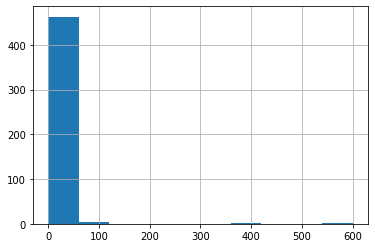

In [0]:
df.NumFriends.hist()

As seen in the histogram, the distribution of `NumFriends` is heavily right-skewed. Apply log-transform to `NumFriends` and observe its distribution now:

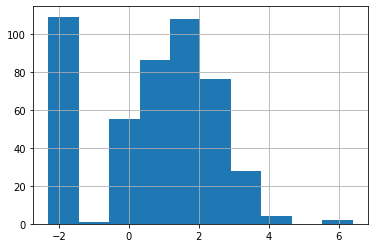

In [0]:
np.log(df['NumFriends']+0.1).hist()

The distribution now looks more balanced. Rename `NumFriends` as `logNumFriends`:

In [0]:
#apply log transform to column
df['NumFriends'] = np.log(df['NumFriends']+0.1)

#rename column
df.rename(columns={'NumFriends':'logNumFriends'}, inplace=True)

df.head()

,Gender,SexualOrientation,Age,IncomeLevel,Race,Body,ProstitutionLegalAtPlace,WouldPayForSex,logNumFriends,HasSocialAnxiety,Education,DepressionSeverity
0,Male,Straight,35,"$30,000 to $39,999",White non-Hispanic,Normal weight,No,No,-2.302585,Yes,Associate degree,2
1,Male,Bisexual,21,"$1 to $10,000",White non-Hispanic,Underweight,No,No,-2.302585,Yes,"Some college, no degree",0
2,Male,Straight,22,$0,White non-Hispanic,Overweight,No,No,2.312535,Yes,"Some college, no degree",0
3,Male,Straight,19,"$1 to $10,000",White non-Hispanic,Overweight,Yes,No,2.091864,Yes,"Some college, no degree",0
4,Male,Straight,23,"$30,000 to $39,999",White non-Hispanic,Overweight,No,Yes and I have,2.312535,No,"High school graduate, diploma or the equivalen...",0


##Median imputing

In datasets of any size, there can be missing data or outliers. If the number of such data is very small relative to the size of the dataset, removing these entries from the dataset may not significantly impact model performance. 

However, for small datasets such as this one, median imputing is often a better solution in order to preserve as much training data as possible.

First, check for missingness:

In [0]:
df.isnull().sum()

Gender                      0
SexualOrientation           0
Age                         0
IncomeLevel                 0
Race                        0
Body                        0
ProstitutionLegalAtPlace    0
WouldPayForSex              0
logNumFriends               0
HasSocialAnxiety            0
Education                   0
DepressionSeverity          0
dtype: int64

There are no missing values in the dataset.

Next, inspect the values of categorical features - do they make sense?


In [0]:
for column in df.columns:
    #skip through numerical variables
    if column != 'logNumFriends' and column != 'Age' and column != 'DepressionSeverity':
        print(f'columns: {column}\nInput set:{df[column].unique()}\n')

columns: Gender
Input set:['Male' 'Female' 'Transgender male' 'Transgender female']

columns: SexualOrientation
Input set:['Straight' 'Bisexual' 'Gay/Lesbian']

columns: IncomeLevel
Input set:['$30,000 to $39,999' '$1 to $10,000' '$0' '$50,000 to $74,999'
 '$20,000 to $29,999' '$10,000 to $19,999' '$75,000 to $99,999'
 '$174,999 to $199,999' '$100,000 to $124,999' '$40,000 to $49,999'
 '$200,000 or more']

columns: Race
Input set:['White non-Hispanic' 'Hispanic (of any race)' 'Asian' 'white and asian'
 'caucasian' 'Black' 'Middle Eastern' 'half Arab' 'Mixed race' 'Pakistani'
 'helicopterkin' 'Turkish' 'Indian' 'Native american' 'Mixed' 'mixed'
 'Mixed white/asian' 'indian' 'Multi' 'Native American mix'
 'North African' 'Half Asian half white' 'White and Native American'
 'First two answers. Gender is androgyne, not male; sexuality is asexual, not bi.'
 'European']

columns: Body
Input set:['Normal weight' 'Underweight' 'Overweight' 'Obese']

columns: ProstitutionLegalAtPlace
Input set:

Some values do not make sense. It is possible to replace these values with the most common value from that variable. However, as the responses seem untrue, I chose to remove these entries entirely  to preserve the quality of my training data, 

In [0]:
#Remove rows with irrelevant data under Race,
print(df.loc[df.Race =='First two answers. Gender is androgyne, not male; sexuality is asexual, not bi.'].index)
print(df.loc[df.Race == 'helicopterkin'].index)

df = df.drop(414, axis=0) 
df = df.drop(150, axis=0) 

Int64Index([414], dtype='int64')
Int64Index([150], dtype='int64')


Finally, look for outliers in the numerical variable `logNumFriends`, and impute them with the variable's median:

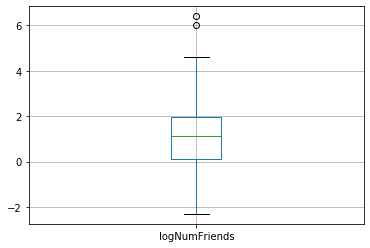

In [0]:
df.boxplot(column =['logNumFriends'], grid = True)

In [0]:
#locate outliers 
outlier_index = list(df.loc[df.logNumFriends > 4].logNumFriends.index)

#impute outliers with median
df.loc[outlier_index, 'logNumFriends'] = df.logNumFriends.median()

#check
df.logNumFriends[outlier_index]

92     1.131402
164    1.131402
257    1.131402
314    1.131402
315    1.131402
435    1.131402
Name: logNumFriends, dtype: float64

## One-hot encoding features

Models can only process numerical data. All categorical variables must be converted into numerical variables.

To begin, create a yes/no map:

In [0]:
#defining yes/no map
No_map = {'Yes': 1, 'No': 0}

`No_map` encodes `"yes"`/`"no"` inputs into numerical values `1`/`0`. It will be used to numerically label `ProstitutionLegalAtPlace` and `HasSocialAnxiety`. 

Convert values of both variables:

In [0]:
df.ProstitutionLegalAtPlace.replace(No_map,inplace=True)
df.HasSocialAnxiety.replace(No_map,inplace=True)

#verify conversion
df.head()

,Gender,SexualOrientation,Age,IncomeLevel,Race,Body,ProstitutionLegalAtPlace,WouldPayForSex,logNumFriends,HasSocialAnxiety,Education,DepressionSeverity
0,Male,Straight,35,"$30,000 to $39,999",White non-Hispanic,Normal weight,0,No,-2.302585,1,Associate degree,2
1,Male,Bisexual,21,"$1 to $10,000",White non-Hispanic,Underweight,0,No,-2.302585,1,"Some college, no degree",0
2,Male,Straight,22,$0,White non-Hispanic,Overweight,0,No,2.312535,1,"Some college, no degree",0
3,Male,Straight,19,"$1 to $10,000",White non-Hispanic,Overweight,1,No,2.091864,1,"Some college, no degree",0
4,Male,Straight,23,"$30,000 to $39,999",White non-Hispanic,Overweight,0,Yes and I have,2.312535,0,"High school graduate, diploma or the equivalen...",0


The variables `race` and `education` contains many unique inputs which can be further classified. Creating respective maps and reclassify:

In [0]:
#Education map:
Education_map = {"Master’s degree": 'MastersAndBeyond', "Doctorate degree": 'MastersAndBeyond', 
                 'Professional degree': 'MastersAndBeyond', 
                 'Associate degree': 'CollegeOrEquivalent', 'Some college, no degree': 'CollegeOrEquivalent', 
                 'High school graduate, diploma or the equivalent (for example: GED)': 'Highschool', 
                 'Bachelor’s degree': 'CollegeOrEquivalent', 'Trade/technical/vocational training': 'CollegeOrEquivalent', 
                 'Some high school, no diploma': 'Highschool'}

#race map
Race_map = {'Mixed': 'Others','mixed': 'Others','Mixed race': 'Others','Multi': 'Others','Half Asian half white': 'Others',
            'White and Native American': 'Others','white and asian': 'Others','half Arab': 'Others',
            'Mixed white/asian': 'Others','Native American mix': 'Others',
            'White non-Hispanic': 'Caucasian', 'caucasian': 'Caucasian', 'European': 'Caucasian', 'Turkish': 'Others',
            'Indian': 'Asian', 'indian': 'Asian', 'Asian': 'Asian', 'Pakistani': 'Asian',
            'Hispanic (of any race)': 'Hispanic',
            'Middle Eastern': 'Others', 'Native american': 'Others',
            'North African': 'Black'
            }
#reclassify
df.Race.replace(Race_map,inplace=True)
df.Education.replace(Education_map,inplace=True)

Finally, one-hot-encode all variables that still contain categorical values. One-hot encoding converts categorical values into new columns with {0,1} values.

Define a one-hot-encoding function:

In [0]:
#define a one-hot encoding function
'''
Iterate through each variable in the dictionary. 
For each value in the array of unique values, look up each value in column. 
If values match, assign 1, else assign 0 to new column in dataframe.
Return dataframe.
'''
def one_hot_encode(df, unique_values_dict):
    for key, value in unique_values_dict.items(): #for each variable,
        for unique_value in value: #for each value in the array of unique values,
            df[unique_value] = df[key].apply(lambda x: 1 if x == unique_value else 0)
        df = df.drop(columns=[key])
    return df

In [0]:
#create a dictionary with {key, val} of {variable, set of unqiue values}
unique_values = {'Gender': df.Gender.unique(), 'SexualOrientation': df.SexualOrientation.unique(), 
                'IncomeLevel': df.IncomeLevel.unique(), 'Race': df.Race.unique(),
                'Body': df.Body.unique(), 'Education': df.Education.unique(), 
                'WouldPayForSex': df.WouldPayForSex.unique(),}

#one-hot-encode `df_oneHot` and assign to new variable, `df_oneHot`
df_oneHot = one_hot_encode(df, unique_values)

#renaming new columns from `WouldPayForSex`:
df_oneHot = df_oneHot.rename(columns = {'No': 'No_WouldPayForSex', 'Yes and I have': 'YesAndHave_WouldPayForSex', "Yes but I haven't": 'YesButHaveNot_WouldPayForSex'})

#renaming `DepressionSeverity` to `Target`,
df_oneHot.rename({'DepressionSeverity': 'Target'},axis=1, inplace=True)

#how does df_oneHot look like?
df_oneHot

,Age,ProstitutionLegalAtPlace,logNumFriends,HasSocialAnxiety,Target,Male,Female,Transgender male,Transgender female,Straight,Bisexual,Gay/Lesbian,"$30,000 to $39,999","$1 to $10,000",$0,"$50,000 to $74,999","$20,000 to $29,999","$10,000 to $19,999","$75,000 to $99,999","$174,999 to $199,999","$100,000 to $124,999","$40,000 to $49,999","$200,000 or more",Caucasian,Hispanic,Asian,Others,Black,Normal weight,Underweight,Overweight,Obese,CollegeOrEquivalent,Highschool,MastersAndBeyond,No_WouldPayForSex,YesAndHave_WouldPayForSex,YesButHaveNot_WouldPayForSex
0,35,0,-2.302585,1,2,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,21,0,-2.302585,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
2,22,0,2.312535,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0
3,19,1,2.091864,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0
4,23,0,2.312535,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,26,0,2.312535,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1
465,31,0,2.312535,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1
466,17,0,3.000720,1,2,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0
467,18,0,2.778819,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0


Now all variables have numeric inputs. `df_cleaned_oneHot` now contains the target column, numerical columns `Age` and `logNumFriends` and columns with {0,1} values for each category under each categorical variable.

#Model Training and Validation

Predicting depression severity is a multiclass classficiation problem. I used three appropriate models, Mutlinomial Logistic Regression, Decision Tree and Random Forest and compare their performances.

##Metric

Given that the problem is a multi-classification problem, and taking into account of data imbalance observed between the three labels, I chose $f_{2}$ as my scoring metric. 

$f_{β}$ is the weighted harmonic mean between precision and recall:

<br>
<center>$f_{β} = (1+β^2) \cdot \frac{precision \cdot recall}{(β^2 \cdot precision) + recall}, β\in \mathbb{R} $</center>
<center>with β < 1 favoring precision and β > 1 favoring recall</center>
<br>

Precision and recall are suitable metrics for imbalanced target values. $f_{β}$ is chosen as a means to succinctly represent the precision and recall scores. 

**As it is less consequential to mislabel a healthy person as depressed than to miss out on truly depressed individuals (false positives over false negatives), I assigned β as 2 to favor recall.**

Define a function that runs model prediction and returns the model's $f_{2}$ score:

In [0]:
def evaluate_model(model, x_test, y_test, beta: int = 2):
    y_pred = model.predict(x_test)
    return fbeta_score(y_test, y_pred, beta=beta, average='weighted')

##Models

For each model, split the dataset into train and validation sets. Then, fit the models and evaluate their performances on the validation set.


Split data into training and validation sets:

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_oneHot.drop('Target',1),
                                                    df_oneHot['Target'],
                                                    test_size=0.20, random_state=1)

### Multinomial Logistic

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score

# initialize multinomial logistic regression model
multilog = LogisticRegression(penalty='l2',class_weight ='balanced', multi_class='multinomial',solver='lbfgs')

# Train the model
multilog.fit(x_train, y_train)

# Validate the model
f_multilog = evaluate_model(model=multilog, x_test=x_test, y_test=y_test, beta=2)
print(f'f2_score of multilog: {f_multilog}')

f2_score of multilog: 0.590006015704154


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

# initialize decision tree
dt = DecisionTreeClassifier(random_state=1,max_depth=14, class_weight='balanced')

# train
dt.fit(x_train, y_train)

# validate
f_dt = evaluate_model(model=dt, x_test=x_test, y_test=y_test, beta=2)
print(f'f2_score of dt: {f_dt}')

f2_score of dt: 0.7635141392468935


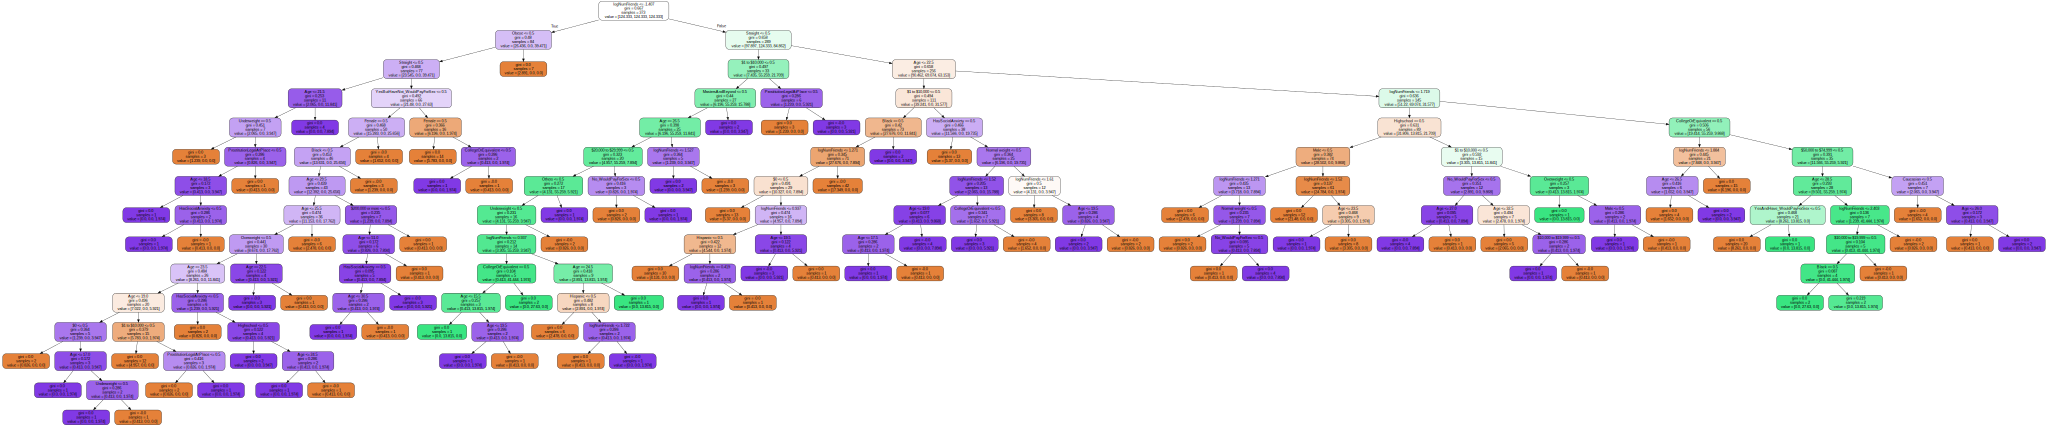

In [0]:
from IPython.display import SVG
from graphviz import Source
from sklearn.tree import export_graphviz
from subprocess import call #QUES: arragne imports in alphabetical sequence ?

# Visualize the decision tree
dt_graph = Source(export_graphviz(dt,
                                    feature_names = list(df_oneHot.loc[:, df_oneHot.columns != 'Target'].columns),
                                    rounded = True, proportion = False, 
                                    filled = True))
SVG(dt_graph.pipe(format='svg'))
#QUES: how to reduce size?

The `dt` model selected as `logNumFriends` as the root node. We can then infer that the number of friends one has is the most important predictor of depression severity.

To improve `dt`'s performance, I performed hyperparameter-tuning on its maximum depth:

highest f score
 f_score    0.774136
dtype: float64

achieved at max depth of
 f_score    13
dtype: int64


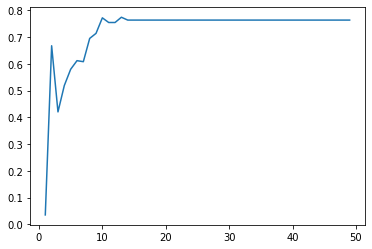

In [0]:
#define the range of tuning maximum depths 
max_depths = list(range(1, 50))

#create a variable to store f scores
scores = pd.DataFrame(columns=['f_score'], index=max_depths)

#begin tuning maximum depths 
for i in max_depths:
    #initialize a decision tree model with max depth i
    dt_maxDepth =  DecisionTreeClassifier(random_state=1,max_depth=i, class_weight='balanced')

    #train
    dt_maxDepth.fit(x_train, y_train)

    #validate and obtain f score 
    scores.at[i, 'f_score'] = evaluate_model(model=dt_maxDepth, x_test=x_test, y_test=y_test, beta=2)

#plot results
plt.plot(scores.f_score)

#display max depth that gives highest f score
print('highest f score\n', scores.max())
print('\nachieved at max depth of\n',scores.astype('float64').idxmax())

The optimum maximum depth for `dt` is 13. Updating `f_dt` with highest score:

In [0]:
f_dt = scores.max()[0]

###Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#initialize random forest model
rf = RandomForestClassifier(n_estimators = 100, max_depth = 9, random_state  = 1,
                                class_weight='balanced')

#train
rf.fit(x_train,y_train)

#validate
f_rf = evaluate_model(model=rf, x_test=x_test, y_test=y_test, beta=2)
print(f'f2_score of rf: {f_rf}')

f2_score of rf: 0.8539051143121449


Tune the maximum depth hyperparameter: 

highest f score
 f_score    0.853905
dtype: float64

achieved at max depth of
 f_score    9
dtype: int64


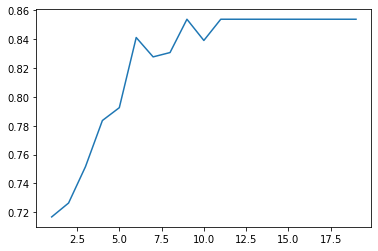

In [0]:
#define the range of tuning maximum depths 
max_depths = list(range(1, 20))

#create a variable to store f scores
scores = pd.DataFrame(columns=['f_score'], index=max_depths)

#begin tuning maximum depths 
for i in max_depths:
    rf_maxDepth = RandomForestClassifier(n_estimators = 100, max_depth = i, random_state  = 1,
                                class_weight='balanced')
    rf_maxDepth.fit(x_train, y_train)
    scores.at[i, 'f_score'] = evaluate_model(model=rf_maxDepth, x_test=x_test, y_test=y_test, beta=2)

#plot results
plt.plot(scores.f_score)

#display max depth that gives highest f score
print('highest f score\n', scores.max())
print('\nachieved at max depth of\n',scores.astype('float64').idxmax())

The optimum maximum depth for `rf` is 9. 

Update `rf` with highest score:

In [0]:
f_rf = scores.max()[0]

##Summary

Compare f-scores between all three models:

In [0]:
print(f'F scores:\nMultilog: {f_multilog:.5f}\n'
      f'Decision Tree: {f_cart:.5f}\n'
      f'Random Forest: {f_rf:.5f}\n')

F scores:
Multilog: 0.59001
Decision Tree: 0.77414
Random Forest: 0.85391



Random Forest had the best performance at 85.4%, with Decision Tree following second at 77.4% and finally Multinomial Logsitic Regression as the worst-performing model at 59.0%.

#Model Prediction 

After training and validating the models using the **ForeverAlone** dataset, it is time to test them on data unseen by the model. 

Using the same questions on the survey that was used to construct the selected features on the ForeverAlone dataset, a new dataset, **Lonely**, was created, by sending out Google Forms online and in-person. The feature questions were taken as is to avoid confounding effects. Target respondents were university students to support ongoing efforts to promote mental health in my univeristy. 

##Import Lonely dataset

Import and store dataset as a Pandas dataframe in `dfL`:

In [0]:
dfL = pd.read_csv("{}/TheLonelySurvey.csv".format(data_dir))
dfL.head()

,Timestamp,Are you a university student?,How old are you?,Do you have social anxiety?,Are you depressed?,Have you ever contemplated/attempted suicide?,What gender do you identify as?,What is your sexual orientation?,What race do you identify as?,What is your education level?,How many friends do you have in real life? (whole number),How would you describe your body weight?,What is your income range?,Is prostitution Legal at where you live?,Would you pay for sex?
0,2019/11/19 12:56:53 AM EST,Yes,20.0,Yes,No,Contemplated suicide,Male,Bisexual,Hispanic,University,4,Normal weight,"$1-$9,999",No,No
1,2019/11/19 12:59:40 AM EST,Yes,20.0,Yes,Yes,Never,Female,Straight,Hispanic,University,4,Normal weight,"$100,000 - $124,999",No,No
2,2019/11/19 1:02:00 AM EST,Yes,22.0,Yes,Yes,Contemplated suicide,Male,Straight,Asian,University,50,Normal weight,"$1-$9,999",Yes,Yes
3,2019/11/19 1:05:33 AM EST,Yes,22.0,No,No,Never,Male,Straight,Asian,University,10,Normal weight,"$10,000 - $19,999",No,No
4,2019/11/19 1:11:54 AM EST,Yes,19.0,Yes,No,Contemplated suicide,Female,Bisexual,Asian,High school,8,Normal weight,$0,No,No


Rename columns:

In [0]:
dfL.columns = ['Timestamp', 'UniStudent', 'Age', 'HasSocialAnxiety', 'Depressed', 'Suicide', 'Gender', 'SexualOrientation','Race','Education','NumFriends','Body','IncomeLevel','ProstitutionLegalAtPlace','WouldPayForSex']
dfL.head()

,Timestamp,UniStudent,Age,HasSocialAnxiety,Depressed,Suicide,Gender,SexualOrientation,Race,Education,NumFriends,Body,IncomeLevel,ProstitutionLegalAtPlace,WouldPayForSex
0,2019/11/19 12:56:53 AM EST,Yes,20.0,Yes,No,Contemplated suicide,Male,Bisexual,Hispanic,University,4,Normal weight,"$1-$9,999",No,No
1,2019/11/19 12:59:40 AM EST,Yes,20.0,Yes,Yes,Never,Female,Straight,Hispanic,University,4,Normal weight,"$100,000 - $124,999",No,No
2,2019/11/19 1:02:00 AM EST,Yes,22.0,Yes,Yes,Contemplated suicide,Male,Straight,Asian,University,50,Normal weight,"$1-$9,999",Yes,Yes
3,2019/11/19 1:05:33 AM EST,Yes,22.0,No,No,Never,Male,Straight,Asian,University,10,Normal weight,"$10,000 - $19,999",No,No
4,2019/11/19 1:11:54 AM EST,Yes,19.0,Yes,No,Contemplated suicide,Female,Bisexual,Asian,High school,8,Normal weight,$0,No,No


##EDA and preprocessing Lonely

**NOTE**: The EDA and preprocessing procedures of the Lonely dataset will be very similar to those of the training datatset. Feel free to skip ahead to the **Predict Lonely** section. 

The Lonely dataset should only contain the 13 features that were used to train the model. `TimeStamp` and `UniStudent` columns must be dropped.

Discard the `TimeStamp` column:

In [0]:
#drop timestamp 
dfL =  dfL.drop(['Timestamp'], axis = 1)
dfL.head()

,UniStudent,Age,HasSocialAnxiety,Depressed,Suicide,Gender,SexualOrientation,Race,Education,NumFriends,Body,IncomeLevel,ProstitutionLegalAtPlace,WouldPayForSex
0,Yes,20.0,Yes,No,Contemplated suicide,Male,Bisexual,Hispanic,University,4,Normal weight,"$1-$9,999",No,No
1,Yes,20.0,Yes,Yes,Never,Female,Straight,Hispanic,University,4,Normal weight,"$100,000 - $124,999",No,No
2,Yes,22.0,Yes,Yes,Contemplated suicide,Male,Straight,Asian,University,50,Normal weight,"$1-$9,999",Yes,Yes
3,Yes,22.0,No,No,Never,Male,Straight,Asian,University,10,Normal weight,"$10,000 - $19,999",No,No
4,Yes,19.0,Yes,No,Contemplated suicide,Female,Bisexual,Asian,High school,8,Normal weight,$0,No,No


Since university students are my targeted population, I discard responses from non-university students before dropping `UniStudent`:

In [0]:
#locate non-university students,
NotUniStudent_index = dfL.loc[dfL.UniStudent == 'No'].index

#how many non-university respondents?
print(f'There are {len(NotUniStudent_index)} non-uni students in {dfL.shape[0]} respondents.')

#drop non-university respondents
dfL = dfL.drop(NotUniStudent_index)

#verify change
print(f'After dropping, remaining unique value types in UniStudent: {dfL.UniStudent.unique()}')

There are 9 non-uni students in 110 respondents.
After dropping, remaining unique value types in UniStudent: ['Yes']


In [0]:
#drop UniStudent column
dfL = dfL.drop(['UniStudent'], axis = 1)

How big is our dataset?

In [0]:
print(dfL.shape)

(101, 13)


There are 110 rows (corresponding to respondents) and 15 columns (corresponding to the 13 features, timestamp and verifying )

What are the datatypes for each column?

In [0]:
print(dfL.dtypes)

Age                         float64
HasSocialAnxiety             object
Depressed                    object
Suicide                      object
Gender                       object
SexualOrientation            object
Race                         object
Education                    object
NumFriends                    int64
Body                         object
IncomeLevel                  object
ProstitutionLegalAtPlace     object
WouldPayForSex               object
dtype: object


Types of variables matches with training feature types. Proceed.

### Creating target column - DepressionSeverity

Reformat inputs of `Suicide`:

In [0]:
#define a function that classifies ('Contemplated Suicide', 'Never') to 'No'
def classify_attempted_suicide(x):
  if x == 'Attempted suicide' :
    return 'Yes'
  else: return 'No'

#apply reclassification
dfL['Suicide'] = dfL['Suicide'].apply(classify_attempted_suicide)

#verify reclassification
dfL.Suicide.value_counts()

KeyError: ignored

Replace `Depressed` and `Suicide` columns with target column, `DepressionSeverity`:

In [0]:
dfL['DepressionSeverity'] = dfL[['Depressed','Suicide']].apply(classify_severity, axis = 1)
dfL = dfL.drop(['Depressed','Suicide'], axis = 1)

#check
print(dfL.DepressionSeverity.value_counts())

0    90
2     7
1     4
Name: DepressionSeverity, dtype: int64


Note the recurring data imbalance.

### Removing skewness in features,

Is `NumFriends` in our test set skewed? 

Observe the distributions of `NumFriends`:

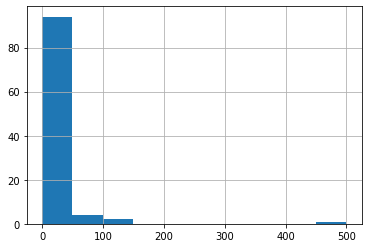

In [0]:
dfL.NumFriends.hist()

As seen in the histogram, it is also heavily right-skewed. 

Apply log-transformation:

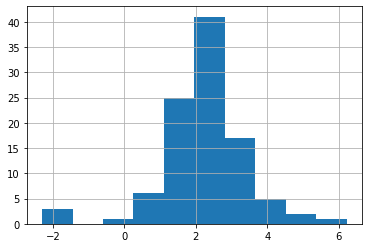

In [0]:
np.log(dfL['NumFriends']+0.1).hist()

The distribution now looks much balanced. 

Rename `NumFriends` as `logNumFriends`:

In [0]:
#apply log transform to column
dfL['NumFriends'] = np.log(dfL['NumFriends']+0.1)

#rename column
dfL.rename(columns={'NumFriends':'logNumFriends'}, inplace=True)

dfL.head()

,Age,HasSocialAnxiety,Gender,SexualOrientation,Race,Education,logNumFriends,Body,IncomeLevel,ProstitutionLegalAtPlace,WouldPayForSex,DepressionSeverity
0,20.0,Yes,Male,Bisexual,Hispanic,University,1.410987,Normal weight,"$1-$9,999",No,No,0
1,20.0,Yes,Female,Straight,Hispanic,University,1.410987,Normal weight,"$100,000 - $124,999",No,No,0
2,22.0,Yes,Male,Straight,Asian,University,3.914021,Normal weight,"$1-$9,999",Yes,Yes,0
3,22.0,No,Male,Straight,Asian,University,2.312535,Normal weight,"$10,000 - $19,999",No,No,0
4,19.0,Yes,Female,Bisexual,Asian,High school,2.091864,Normal weight,$0,No,No,0


###Median imputing

First, check for missingness:

In [0]:
dfL.isnull().sum()

Age                         0
HasSocialAnxiety            0
Gender                      0
SexualOrientation           0
Race                        0
Education                   0
logNumFriends               0
Body                        0
IncomeLevel                 0
ProstitutionLegalAtPlace    0
WouldPayForSex              0
DepressionSeverity          0
dtype: int64

There are no missing values in the test set.

Next, inspect the entries of categorical features - do they make sense?


In [0]:
for column in dfL.columns:
    if column != 'logNumFriends' and column != 'DepressionSeverity':
        print(f'columns: {column}\nInput set:{dfL[column].unique()}\n')

columns: Age
Input set:[20.   22.   19.   23.   18.   28.   21.   24.   38.   19.5  14.88 25.  ]

columns: HasSocialAnxiety
Input set:['Yes' 'No']

columns: Gender
Input set:['Male' 'Female' 'Transgender male' '78% Male 22% Female' 'Chad'
 'Transgender female' 'non binary' 'Non-binary']

columns: SexualOrientation
Input set:['Bisexual' 'Straight' 'Homosexual' 'Pansexual']

columns: Race
Input set:['Hispanic' 'Asian' 'Black' 'South Asian' 'Caucasian'
 'South Asian (assuming that the "Asian" option means "East Asian")'
 'Brown' 'Middle Eastern' 'transracial' 'Octoroon' 'Chad ' 'Jewish'
 'Mixed' 'Turkish' 'Asian/Caucasian' 'Aboriginal '
 'Mixed: Asian, Caucasian and Australian Indigenous ']

columns: Education
Input set:['University' 'High school' 'Masters' 'PHD']

columns: Body
Input set:['Normal weight' 'Overweight' 'Underweight' 'Obese']

columns: IncomeLevel
Input set:['$1-$9,999' '$100,000 - $124,999' '$10,000 - $19,999' '$0'
 '$75,000 -  $99,999' '$30,000 -  $39,999' '$20,000 - $29,

All are valid. Keep all.

Finally, look for outliers in the numerical variable `logNumFriends`:

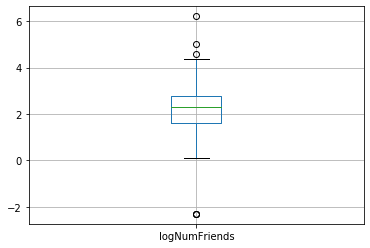

In [0]:
dfL.boxplot(column =['logNumFriends'], grid = True)

In [0]:
#locate outliers 
outlier_index = list(pd.concat([dfL.loc[dfL.logNumFriends > 4], dfL.loc[dfL.logNumFriends < 0]]).logNumFriends.index)

#median-impute outliers
dfL.loc[outlier_index, 'logNumFriends'] = dfL.logNumFriends.median()

#check
dfL.logNumFriends[outlier_index]

19    2.312535
42    2.312535
75    2.312535
90    2.312535
18    2.312535
41    2.312535
51    2.312535
Name: logNumFriends, dtype: float64

### One-hot encoding features

Create a yes/no map:

In [0]:
#defining yes/no map
No_map = {'Yes': 1, 'No': 0}

`No_map` will be used to numerically label `ProstitutionLegalAtPlace` and `HasSocialAnxiety`. 

Convert values:

In [0]:
dfL.HasSocialAnxiety.replace(No_map,inplace=True)
dfL.ProstitutionLegalAtPlace.replace(No_map,inplace=True)

#verify conversion
dfL.head()

,Age,HasSocialAnxiety,Gender,SexualOrientation,Race,Education,logNumFriends,Body,IncomeLevel,ProstitutionLegalAtPlace,WouldPayForSex,DepressionSeverity
0,20.0,1,Male,Bisexual,Hispanic,University,1.410987,Normal weight,"$1-$9,999",0,No,0
1,20.0,1,Female,Straight,Hispanic,University,1.410987,Normal weight,"$100,000 - $124,999",0,No,0
2,22.0,1,Male,Straight,Asian,University,3.914021,Normal weight,"$1-$9,999",1,Yes,0
3,22.0,0,Male,Straight,Asian,University,2.312535,Normal weight,"$10,000 - $19,999",0,No,0
4,19.0,1,Female,Bisexual,Asian,High school,2.091864,Normal weight,$0,0,No,0


Reclassify inputs of `race`, `education`, `IncomeLevel`, `SexualOrientation`, and `Gender`:


In [0]:
#Education map:
Education_map = {"Masters": 'MastersAndBeyond', 
                 "PHD": 'MastersAndBeyond', 
                 'Professional Certificate': 'MastersAndBeyond', 
                 'Community College': 'CollegeOrEquivalent', 
                 'University': 'CollegeOrEquivalent', 
                 'High school': 'Highschool',}

#race map
Race_map = {'Mixed: Asian, Caucasian and Australian Indigenous ':'Asian',
            'South Asian': 'Asian',
            'South Asian (assuming that the "Asian" option means "East Asian")': 'Asian',
            'Brown': 'Asian',
            'Mixed': 'Others',
            'Asian/Caucasian': 'Others',
            'transracial': 'Others',
            'Jewish': 'Caucasian',
            'Turkish': 'Others',
            'Aboriginal ': 'Others',
            'Middle Eastern': 'Others',
            'Octoroon': 'Others',
            'Chad ': 'Black'
            }

#income level map
IncomeLevel_map = {'$1-$9,999': '$1 to $10,000',
                   '$10,000 - $19,999': '$10,000 to $19,999',
                   '$20,000 - $29,999': '$20,000 to $29,999',
                   '$30,000 -  $39,999': '$30,000 to $39,999',
                   '$40,000 -  $49,999': '$40,000 to $49,999',
                   '$50,000 -  $74,999': '$50,000 to $74,999',
                   '$75,000 -  $99,999': '$75,000 to $99,999',
                   '$100,000 - $124,999': '$100,000 to $124,999',
                   '$175,000 - 199,999': '$174,999 to $199,999',
                   '$200,000 or more': '$200,000 or more'
}

#replace values with respective maps
dfL.Race.replace(Race_map,inplace=True)
dfL.Education.replace(Education_map,inplace=True)
dfL.IncomeLevel.replace(IncomeLevel_map, inplace=True)

Reclassify `SexualOrientation` values:

In [0]:
# Combining 'Pansexual' with 'Bisexual' values,
#locate 'Pansexual' values
Pansexual_index = dfL.loc[dfL.SexualOrientation == 'Pansexual'].index

# change 'Pansexual' to 'Bisexual',
dfL.loc[Pansexual_index, 'SexualOrientation'] = "Bisexual"

# Renaming 'Homosexual' to 'Gay/Lesbian',
#locate 'Homosexual' values
Homosexual_index = dfL.loc[dfL.SexualOrientation == 'Homosexual' ].index

#rename
dfL.loc[Homosexual_index, 'SexualOrientation'] = "Gay/Lesbian"

#verify change
dfL.SexualOrientation.value_counts()

Straight       76
Bisexual       17
Gay/Lesbian     8
Name: SexualOrientation, dtype: int64

Remove noise in `Gender`:

In [0]:
#locate noise 
noise_index = list(pd.concat([dfL.loc[dfL.Gender == '78% Male 22% Female'], dfL.loc[dfL.Gender == 'Non-binary'], dfL.loc[dfL.Gender == 'non binary'], dfL.loc[dfL.Gender == 'Chad']]).Gender.index)

#drop noise 
dfL = dfL.drop([41,42,105,85], axis=0) 

#verify change
dfL.Gender.value_counts()

Male                  58
Female                34
Transgender male       3
Transgender female     2
Name: Gender, dtype: int64

Perform one hot encoding on remaining features:

In [0]:
#create a dictionary with {key, val} of {variable, set of unqiue values}
unique_types_dict = {'Gender': dfL.Gender.unique(), 'SexualOrientation': dfL.SexualOrientation.unique(), 
                'IncomeLevel': dfL.IncomeLevel.unique(), 'Race': dfL.Race.unique(),
                'Body': dfL.Body.unique(), 'Education': dfL.Education.unique(), 
                'WouldPayForSex': dfL.WouldPayForSex.unique()}

# one-hot-encode `dfL_oneHot` and assign to new variable, `dfL_oneHot`
dfL_oneHot = one_hot_encode(dfL, unique_values)

# renaming new columns from `WouldPayForSex`:
dfL_oneHot = dfL_oneHot.rename(columns = {'No': 'No_WouldPayForSex', 'Yes and have done so': 'YesAndHave_WouldPayForSex', "Yes": 'YesAndHave_WouldPayForSex'})

# renaming `DepressionSeverity` to `Target`,
dfL_oneHot.rename({'DepressionSeverity': 'Target'},axis=1, inplace=True)

# how does dfL_oneHot look like?
dfL_oneHot

,Age,HasSocialAnxiety,logNumFriends,ProstitutionLegalAtPlace,Target,Male,Female,Transgender male,Transgender female,Straight,Bisexual,Gay/Lesbian,"$30,000 to $39,999","$1 to $10,000",$0,"$50,000 to $74,999","$20,000 to $29,999","$10,000 to $19,999","$75,000 to $99,999","$174,999 to $199,999","$100,000 to $124,999","$40,000 to $49,999","$200,000 or more",Caucasian,Hispanic,Asian,Others,Black,Normal weight,Underweight,Overweight,Obese,CollegeOrEquivalent,Highschool,MastersAndBeyond,No_WouldPayForSex,Yes and I have,Yes but I haven't
0,20.0,1,1.410987,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
1,20.0,1,1.410987,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
2,22.0,1,3.914021,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
3,22.0,0,2.312535,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
4,19.0,1,2.091864,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,18.0,1,0.095310,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
103,20.0,1,1.808289,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
104,20.0,0,3.370738,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
106,20.0,1,2.091864,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0


##Predict Lonely

In [0]:
#split data into features and target
yL_test = dfL_oneHot.Target
xL_test = dfL_oneHot.drop('Target', 1)

#test all models 
multilog.predict(xL_test)
dt.predict(xL_test)
rf.predict(xL_test)

#get prediction scores for all models
fL_multilog = evaluate_model(model=multilog, x_test=xL_test, y_test=yL_test, beta=2)
fL_dt = evaluate_model(model=dt, x_test=xL_test, y_test=yL_test, beta=2)
fL_rf = evaluate_model(model=rf, x_test=xL_test, y_test=yL_test, beta=2)

print(f'Prediction scores:\nMultilog: {fL_multilog:.5f}\n'
      f'dt: {fL_dt:.5f}\n'
      f'Random Forest: {fL_rf:.5f}\n')

Test scores:
Multilog: 0.63550
dt: 0.82736
Random Forest: 0.88613



Random Forest performed the best at 88.6%, with Decision Tree following second at 82.7% and finally Multinomial Logsitic Regression as the worst-performing model at 63.6%.

#Result Analysis

Comparing validation and prediction $f_2$ scores:

In [0]:
print(f'Validation scores:\nMultilog: {f_multilog:.5f}\n'
      f'Decision Tree: {f_dt:.5f}\n'
      f'Random Forest: {f_rf:.5f}\n')

print(f'Prediction scores:\nMultilog: {fL_multilog:.5f}\n'
      f'Decision Tree: {fL_dt:.5f}\n'
      f'Random Forest: {fL_rf:.5f}\n')

Validation scores:
Multilog: 0.59001
Decision Tree: 0.77414
Random Forest: 0.85391

Test scores:
Multilog: 0.63550
Decision Tree: 0.82736
Random Forest: 0.88613



In both validation and prediction, Random Forest gives the best performance based on the chosen metric.

Interestingly, the model performs better on the prediction set. Why? 

Does a high $f_2$ score imply that our model is actually delivering?

To answer the questions above, I plotted confusion matrices for each random forest classification on validation and test sets.

Define a function that returns a confusion matrix plot:

In [0]:
import colorlover as cl
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, dim=500):
    #generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    #defining plot labels
    mapping = {
        '0': 'Not Depressed',
        '1': 'Depressed',
        '2': 'Severely Depressed'
    }

    #assigning labels to corresponding prediciton values
    labels = [mapping[x] for x in np.unique(y_true)]

    # Create confusion matrix plot
    fig = ff.create_annotated_heatmap(
        z=np.flipud(cm),
        x=labels,
        y=list(reversed(labels)),
        colorscale=cl.flipper()['seq']['9']['Blues']
    )
    fig.layout.xaxis.side = 'top'
    fig.layout.height = dim
    fig.layout.width = dim
    
    return fig

In [0]:
print('confusion matrix of rf model on ForeverAlone dataset')
plot_confusion_matrix(y_test, rf.predict(x_test))

RF, multinomial, ForeverAlone, class_weight = balanced


In [0]:
print('confusion matrix of rf model on Lonely dataset')
plot_confusion_matrix(yL_test, rf.predict(xL_test))

RF, multinomial, Lonely, class_weight = balanced


The rows represent the true labels and the columns are the predicted labels. 

From the ForeverAlone dataset, the recall of each label is:
<br>Not Depressed: 98.8%
<br>Depressed: 0%
<br>Severely Depressed: 10%

Whereas for the Lonely dataset, each labels has a recall of:
<br>Not Depressed: 97.7%
<br>Depressed: 0%
<br>Severely Depressed: 20%


The rows represent the true labels and the columns are the predicted labels. 

From both confusion matrices, almost all samples are classified by the model as 'Not Depressed'. 

In both datasets, the Random Forest model has taken advantage of data imbalances. As most samples are Not Depressed, the model classified samples as 'Not Depressed'. By doing so, it has successfully minimized its loss function, but failed to accurately predict Depressed and Severely Depressed samples, which should be the focus of the project. 

To address the data imbalance, I had set `class_weights = 'balanced'` in the model initializions. As the imbalance is very severe, the effects of implementation is almost negligible. Other improvement efforts would be to reduce the scope to binary classification with just two labels. However, it is best to remove the imbalance by collecting more samples for Depressed and Severely Depressed labels.

#Conclusion

Three multiclassification models (Multinomial Logistic Classification, Decision Tree, and Random Forest) were used to classify depression severity. Two datasets were used to train and validate the models (the ForeverAlone dataset), as well as to finally make predictions on (the Lonely dataset). They were both explored and preprocessed, before being fed into the models.

$f_2$ scores were used as an indicator of model performance. Random Forest yielded the highest $f_2$ scores in training and validation, as well as in making predictions, with scores of 85.4% and 88.6% respectively. 

In reality however, the Random Forest model took advantage of imbalances in both datasets by classifying most samples as the Non Depressed, which is most common among the three labels. To truly improve the model's performance, more samples of Depressed and Severely Depressed is required to equilibriate the datasets.